In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### Build the graph

In [2]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

from app.schemas import InterviewState, ResearchGraphState
from app.nodes import generate_question, search_web, search_wikipedia, generate_answer, save_interview, write_section
from app.nodes import create_analysts, human_feedback, write_report, write_conclusion, write_introduction, finalize_report
from app.routes import route_messages, initiate_all_interviews

In [3]:
# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

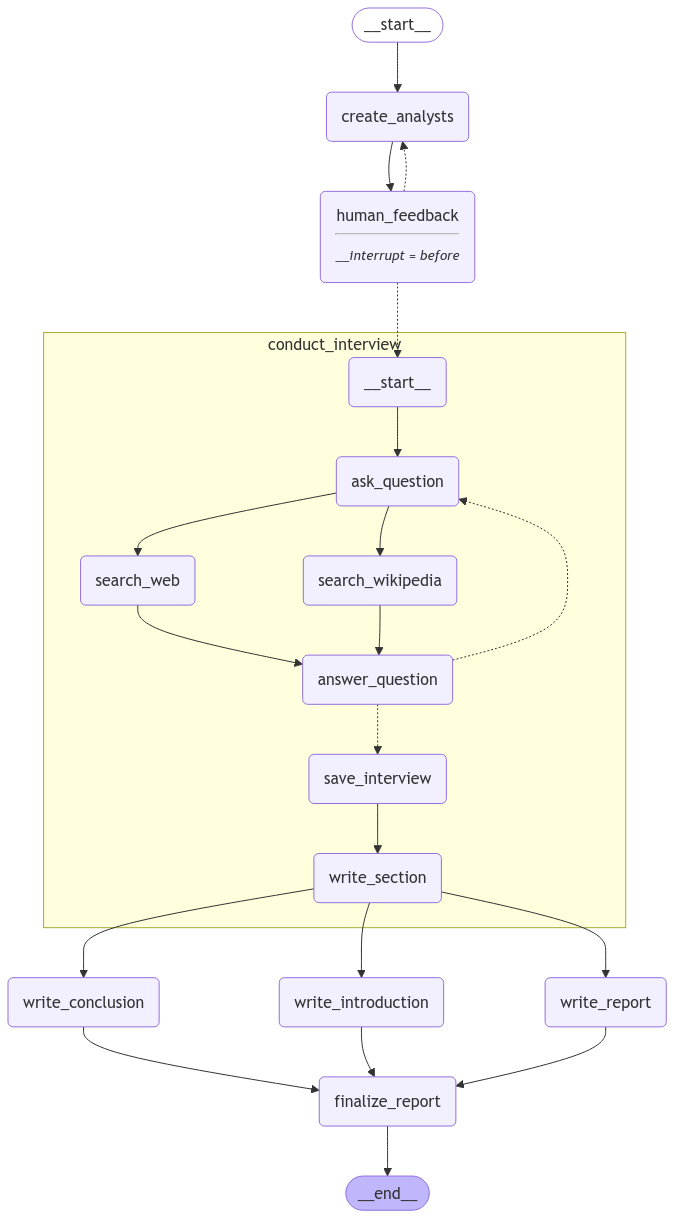

In [4]:
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

### Manual Testing

In [5]:
# Inputs
max_analysts = 3 
topic = "The current state of game development for indie developers from a business perspective"
thread = {"configurable": {"thread_id": "3"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alex Johnson
Affiliation: Indie Game Developers Association
Role: Business Strategist
Description: Alex focuses on the business strategies of indie game developers, analyzing market trends, funding opportunities, and monetization strategies to help developers succeed in a competitive landscape.
--------------------------------------------------
Name: Maria Chen
Affiliation: Game Development Research Institute
Role: Market Analyst
Description: Maria specializes in market analysis for indie games, examining consumer behavior, sales data, and emerging trends to provide insights that can guide indie developers in their marketing and distribution efforts.
--------------------------------------------------
Name: David Lee
Affiliation: Tech Innovations in Gaming
Role: Technology Consultant
Description: David explores the technological advancements impacting indie game development, including tools, platforms, and distribution channels, and how these innovations can be leveraged by indie 

In [6]:
graph.update_state(thread, {"human_analyst_feedback": 
                                "Instead of the Technology Consultant, add a solo game developer"}, as_node="human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe3f57-ecf0-6030-8002-d1669e47b682'}}

In [7]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Alex Johnson
Affiliation: Indie Game Developers Association
Role: Business Strategist
Description: Alex focuses on the business strategies of indie game developers, analyzing market trends, funding opportunities, and monetization strategies to help developers succeed in a competitive landscape.
--------------------------------------------------
Name: Maria Chen
Affiliation: Game Development Research Institute
Role: Market Analyst
Description: Maria specializes in market analysis for indie games, examining consumer behavior, sales data, and emerging trends to provide insights that can guide indie developers in their marketing and distribution efforts.
--------------------------------------------------
Name: David Lee
Affiliation: Tech Innovations in Gaming
Role: Technology Consultant
Description: David explores the technological advancements impacting indie game development, including tools, platforms, and distribution channels, and how these innovations can be leveraged by indie 

In [8]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe3f5b-6e20-6af6-8004-a426f69677c2'}}

In [9]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [10]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Current State of Game Development for Indie Developers: A Business Perspective

## Introduction

The indie game development landscape is a dynamic and challenging arena, where creativity meets financial constraints. This report delves into the current state of indie game development, exploring the unique challenges and opportunities faced by independent developers. We examine the pressing issues of funding and marketing, highlighting the importance of crowdfunding and community engagement. Additionally, we analyze the transformative trends of 2023, including the rise of digital distribution and innovative partnerships. By understanding these elements, indie developers can navigate the complexities of the market and enhance their chances of success in an increasingly competitive environment.

---



The current state of indie game development presents a dynamic landscape filled with both challenges and opportunities. Indie developers are increasingly navigating a complex environment characterized by financial constraints, market saturation, and evolving player preferences. Despite these hurdles, the indie scene is marked by creativity and innovation, with developers finding unique ways to thrive.

Funding remains a critical issue for indie developers, who often rely on personal savings, crowdfunding, and community support to finance their projects. Crowdfunding platforms like Kickstarter can provide essential resources, but competition for visibility is intense, making a compelling pitch crucial for success. The rise of digital distribution channels has democratized access to the market, allowing indie games to reach wider audiences. However, the fear of an "indiepocalypse," where an oversupply of games leads to market saturation, poses a significant challenge for discoverability and profitability.

In 2023, the indie game development landscape is undergoing a transformative phase, driven by technological advancements and changing player preferences. Developers are increasingly exploring alternative engines and adjusting budgets to align with market shifts. This adaptability is vital as the industry recognizes the unique contributions of indie games, which often prioritize creativity over the high-budget productions typical of AAA titles. Community-driven marketing strategies, such as engagement through Twitch and social media, have proven effective in building loyal player bases and enhancing brand narratives.

Partnerships with established publishers are becoming increasingly important for indie developers, providing essential funding, marketing expertise, and distribution networks. These collaborations enable indie games to reach broader audiences and achieve greater success. At the same time, self-publishing and crowdfunding are gaining traction, allowing developers to maintain creative control while accessing financial resources. This democratization of game development fosters a more inclusive gaming community.

Recent surveys indicate a growing interest in diverse funding strategies, including bootstrapping, grants, and investments from angel investors or venture capitalists. This multifaceted approach allows developers to secure necessary resources while minimizing reliance on a single funding source. The collaboration between indie developers and smaller publishers is reshaping the funding landscape, providing both financial backing and valuable industry insights.

In summary, while the indie game development space is fraught with challenges, it also offers unique opportunities for innovation and creativity. By understanding the landscape and employing effective strategies, including strategic partnerships and community engagement, indie developers can enhance their chances of success in this competitive arena.


---

## Conclusion

The current state of indie game development presents a complex yet promising landscape for creators. As explored in this report, indie developers face significant challenges, particularly in funding and market visibility, but they are also empowered by innovative strategies and community engagement. The rise of digital distribution and alternative funding models, including crowdfunding and partnerships with publishers, has opened new avenues for success. Furthermore, the adaptability of indie developers in response to evolving market trends highlights their resilience and creativity. By leveraging these insights and strategies, indie developers can navigate the competitive gaming environment and carve out their unique space in the industry.

## Sources
[1] https://www.yellowbrick.co/blog/entertainment/navigating-challenges-in-the-indie-game-industry  
[2] https://verticalslicegames.com/news/indie-game-developers-face-challenges/  
[3] https://gamingclubly.com/game-dev-insights/challenges-in-indie-game-development/  
[4] https://en.wikipedia.org/wiki/Indie_game  
[5] https://www.superjumpmagazine.com/the-state-of-indie-games-in-2023-and-beyond/  
[6] https://fungies.io/gaming-market-report-and-trends-in-2023/  
[7] https://indiegameacademy.com/embracing-evolution-a-deep-dive-into-the-latest-trends-in-indie-game-development-8/  
[8] https://www.gamemarketinggenie.com/blog/game-marketing-in-2023-5-effective-ways-to-reach-gamers/  
[9] https://fungies.io/marketing-channels-for-your-indie-game-that-work/  
[10] https://data40.com/articles/indie-game-marketing-reaching-audiences-in-a-crowded-market/  
[11] https://kdpkit.com/indie-publishers-a-new-era-of-support-success-and-creative-challenges/  
[12] https://www.superjumpmagazine.com/state-of-indie-games-survey-2023/  
[13] https://wardrome.com/bootstrap-to-breakout-funding-strategies-for-indie-game-developers/  
[14] https://www.sanlo.io/resources/all-about-indie-game-fund